<a href="https://colab.research.google.com/github/radlessss/-computer-vision/blob/main/Lab1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from scipy.ndimage import gaussian_filter

import torchvision
from torchvision import transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_path = "/content/drive/MyDrive/Copy of Animals-10.zip"
data_dir = "/content/dataset/"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

os.listdir(data_dir)

['raw-img', 'translate.py']

In [5]:
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "dog": "cane", "horse": "cavallo", "elephant": "elefante",
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto",
    "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

path = "/content/dataset/raw-img"

data = {"imgpath": [], "labels": []}

categories = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

for folder in categories:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)

    for file in filelist:
        fpath = os.path.join(folderpath, file)
        label = translate.get(folder, folder)

        data["imgpath"].append(fpath)
        data["labels"].append(label)

df = pd.DataFrame(data)

lb = LabelEncoder()
df["encoded_labels"] = lb.fit_transform(df["labels"])

df.head()

imgpath labels  encoded_labels
0  /content/dataset/raw-img/cavallo/OIP-poBuFdlwx...  horse               6
1  /content/dataset/raw-img/cavallo/OIP-1ty7bgeO3...  horse               6
2  /content/dataset/raw-img/cavallo/OIP-tEXdTAmr5...  horse               6
3  /content/dataset/raw-img/cavallo/OIP-Z2DiLPsLt...  horse               6
4  /content/dataset/raw-img/cavallo/OIP-vdna1UkZF...  horse               6

In [6]:
print("Shape of the dataset: ", df.shape)
print("_______________________________________")
print("Number of null values: ")
print(df.isnull().sum())
print("_______________________________________")
print("Number of unique values: ")
print(df.nunique())

print("_______________________________________")
print("Number of images per category : ")
print(df.labels.value_counts())

Shape of the dataset:  (26179, 3)
_______________________________________
Number of null values: 
imgpath           0
labels            0
encoded_labels    0
dtype: int64
_______________________________________
Number of unique values: 
imgpath           26179
labels               10
encoded_labels       10
dtype: int64
_______________________________________
Number of images per category : 
labels
dog          4863
ragno        4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: count, dtype: int64


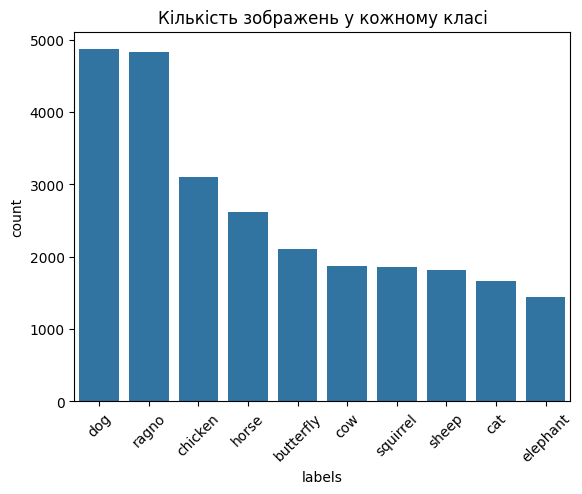

In [7]:
sns.barplot(df.labels.value_counts())
plt.xticks(rotation=45)
plt.title("Кількість зображень у кожному класі")
plt.show()

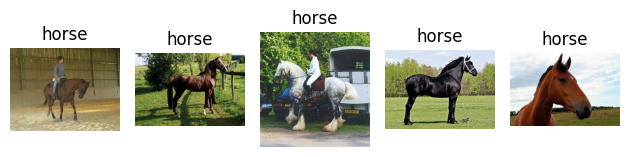

In [8]:
for i in range(5):
    img_path = df["imgpath"].iloc[i]
    label = df["labels"].iloc[i]

    img = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_dir = "/path_to_data/train"
val_dir = "/path_to_data/val"
test_dir = "/path_to_data/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for label in df["labels"].unique():
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

train_df, temp_df = train_test_split(df, test_size=1 - train_ratio, stratify=df["encoded_labels"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=test_ratio / (val_ratio + test_ratio), stratify=temp_df["encoded_labels"], random_state=42)

def move_images(df, split_dir):
    for _, row in df.iterrows():
        img_path = row["imgpath"]
        label = row["labels"]
        target_dir = os.path.join(split_dir, label)
        shutil.copy(img_path, target_dir)

move_images(train_df, train_dir)
move_images(val_df, val_dir)
move_images(test_df, test_dir)

In [11]:
print(len(train_df), len(val_df), len(test_df))

print("Train:")
print(train_df["labels"].value_counts())
print("_______________________________________")

print("\nValidation:")
print(val_df["labels"].value_counts())
print("_______________________________________")

print("\nTest:")
print(test_df["labels"].value_counts())

15707 5236 5236
Train:
labels
dog          2918
ragno        2892
chicken      1859
horse        1574
butterfly    1267
cow          1119
squirrel     1117
sheep        1092
cat          1001
elephant      868
Name: count, dtype: int64
_______________________________________

Validation:
labels
dog          972
ragno        965
chicken      620
horse        524
butterfly    422
cow          374
squirrel     372
sheep        364
cat          334
elephant     289
Name: count, dtype: int64
_______________________________________

Test:
labels
dog          973
ragno        964
chicken      619
horse        525
butterfly    423
cow          373
squirrel     373
sheep        364
cat          333
elephant     289
Name: count, dtype: int64


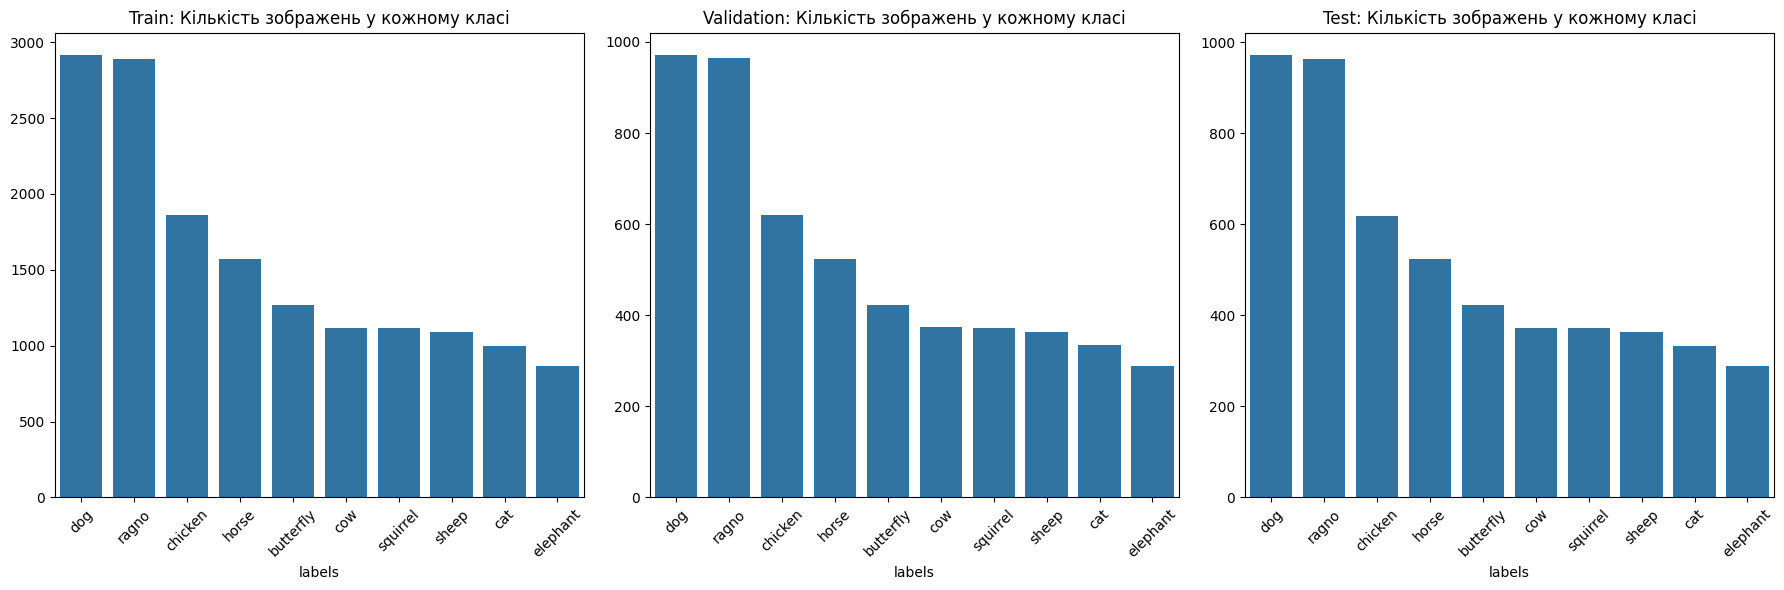

In [19]:
dfs = [train_df, val_df, test_df]
titles = ["Train", "Validation", "Test"]

plt.figure(figsize=(18, 6))

for i, (df, title) in enumerate(zip(dfs, titles)):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=df.labels.value_counts().index, y=df.labels.value_counts().values)
    plt.xticks(rotation=45)
    plt.title(f"{title}: Кількість зображень у кожному класі")

plt.tight_layout()
plt.show()

In [13]:
train_df.head()

imgpath labels  \
25748  /content/dataset/raw-img/pecora/OIP-DQMgd3-aHz...  sheep   
3594   /content/dataset/raw-img/cane/OIP-ZMRF9ybyc82r...    dog   
4726   /content/dataset/raw-img/cane/OIP-k5OWzMIGuiXy...    dog   
4852   /content/dataset/raw-img/cane/OIP-3_l_T4_hU5o2...    dog   
16679  /content/dataset/raw-img/mucca/OIP-6Gv_yZakhAl...    cow   

       encoded_labels  
25748               8  
3594                4  
4726                4  
4852                4  
16679               3

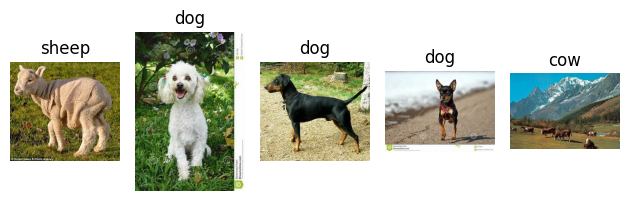

In [20]:
for i in range(5):
    img_path = train_df["imgpath"].iloc[i]
    label = train_df["labels"].iloc[i]

    img = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
data_transforms  ={
    "train": transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]),
    "test": transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
                               )
    }

train = ImageFolder(root="/path_to_data/train", transform=data_transforms["train"])
test = ImageFolder(root="/path_to_data/test", transform=data_transforms["test"])
valid = ImageFolder(root="/path_to_data/val", transform=data_transforms["test"])

BATCH_SIZE = 32
train_loader = DataLoader(train,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(test,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

valid_loader = DataLoader(valid,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

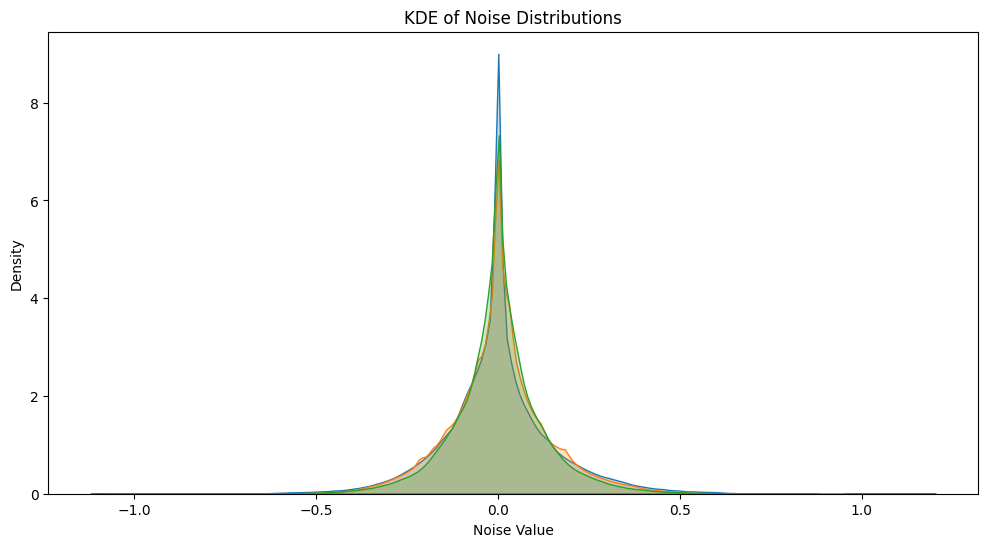

In [40]:
def compute_noise(image):
    image_np = image.squeeze().numpy()
    smoothed_image = gaussian_filter(image_np, sigma=1)
    noise = image_np - smoothed_image
    return noise

def extract_noise_values(dataloader, n=100):
    noise_vals = []
    count = 0
    for images, labels in dataloader:
        for image, label in zip(images, labels):
            noise = compute_noise(image)
            noise_vals.extend(noise.flatten())
            count += 1
            if count >= n:
                break
        if count >= n:
            break
    return np.array(noise_vals)

train_noise = extract_noise_values(train_loader, n=100)
valid_noise = extract_noise_values(valid_loader, n=100)
test_noise  = extract_noise_values(test_loader, n=100)

plt.figure(figsize=(12, 6))
sns.kdeplot(train_noise, label="Train", fill=True)
sns.kdeplot(valid_noise, label="Validation", fill=True)
sns.kdeplot(test_noise, label="Test", fill=True)
plt.title("KDE of Noise Distributions")
plt.xlabel("Noise Value")
plt.ylabel("Density")
plt.show()

In [24]:
images, labels = next(iter(train_loader))
print(f"Shape of image batch: {images.shape}")

Shape of image batch: torch.Size([32, 3, 128, 128])


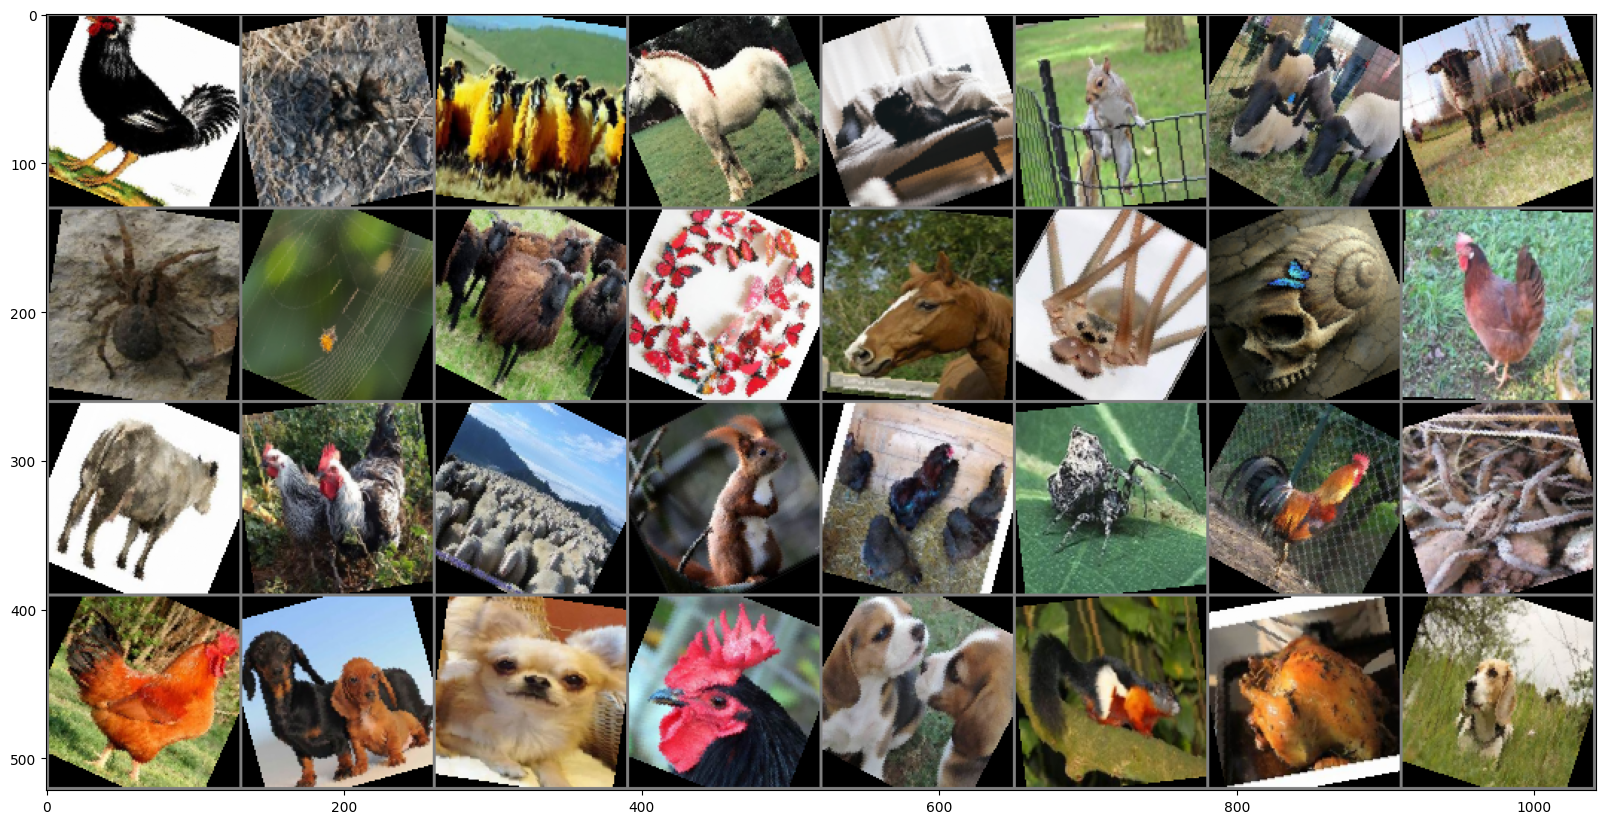

In [25]:
def show_images(imgs):
    plt.figure(figsize=(20, 15))
    plt.imshow(torchvision.utils.make_grid(imgs).permute(1, 2, 0) / 2 + 0.5)
    plt.show()

images, labels = next(iter(train_loader))
show_images(images)

In [26]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        oc = 32

        self.block1 = nn.Sequential(
            nn.Conv2d(3, oc, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(oc, oc * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(oc * 2, oc * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 4),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(oc * 4, oc * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(oc * 8, oc * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(oc * 8 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(256, num_classes)

        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x


model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
print(model)

ConvNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batc

In [27]:
def train(model, train_loader, valid_loader, n_epochs=20, save_file='model1.pt'):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs_no_improve = 0
    max_epochs_stop = 3
    valid_loss_min = np.inf

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0


        model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim=1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            train_acc += accuracy.item()

            print(f'Epoch: {epoch} \t {100 * i / len(train_loader):.2f}% complete.', end='\r')

        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

                ps = torch.exp(output)
                topk, topclass = ps.topk(1, dim=1)
                equals = topclass == target.view(*topclass.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                valid_acc += accuracy.item()

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_acc /= len(train_loader)
        valid_acc /= len(valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        print(f'Training Accuracy: {train_acc * 100:.2f}%\tValidation Accuracy: {valid_acc * 100:.2f}%')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_file)
            valid_loss_min = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f'{epochs_no_improve} epochs with no improvement.')
            if epochs_no_improve >= max_epochs_stop:
                print('Early stopping triggered.')
                break


    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch: 1 	Training Loss: 2.082482 	Validation Loss: 1.832726
Training Accuracy: 25.80%	Validation Accuracy: 33.48%
Validation loss decreased (inf --> 1.832726). Saving model ...

Epoch: 2 	Training Loss: 1.810427 	Validation Loss: 1.598710
Training Accuracy: 37.21%	Validation Accuracy: 44.95%
Validation loss decreased (1.832726 --> 1.598710). Saving model ...

Epoch: 3 	Training Loss: 1.615057 	Validation Loss: 1.476305
Training Accuracy: 44.98%	Validation Accuracy: 48.83%
Validation loss decreased (1.598710 --> 1.476305). Saving model ...

Epoch: 4 	Training Loss: 1.488367 	Validation Loss: 1.267940
Training Accuracy: 49.93%	Validation Accuracy: 57.05%
Validation loss decreased (1.476305 --> 1.267940). Saving model ...

Epoch: 5 	Training Loss: 1.369066 	Validation Loss: 1.395526
Training Accuracy: 53.47%	Validation Accuracy: 52.26%
1 epochs with no improvement.

Epoch: 6 	Training Loss: 1.293903 	Validation Loss: 1.134134
Training Accuracy: 56.37%	Validation Accuracy: 61.93%
Validat

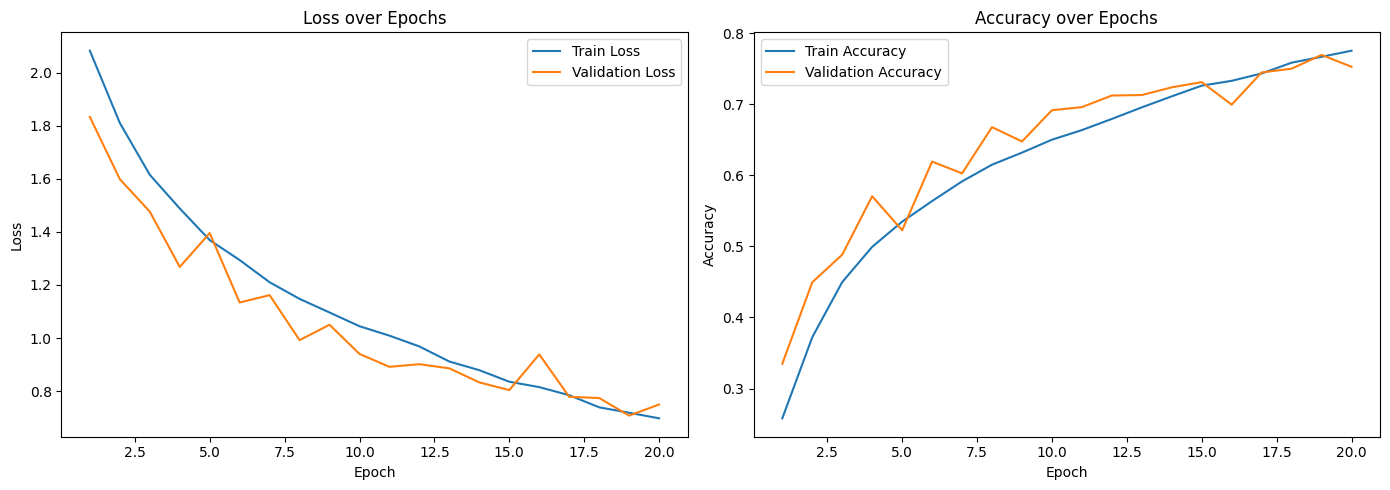

In [28]:
train(model=model, train_loader=train_loader, valid_loader=valid_loader)

In [29]:
criterion = nn.NLLLoss()
classes =  df.labels.unique()

In [30]:
def evaluate(model, state_dict_file, test_loader, criterion, device, classes):
    model.load_state_dict(torch.load(state_dict_file))
    model.to(device)
    model.eval()

    test_loss = 0.0
    num_classes = len(classes)
    class_correct = torch.zeros(num_classes, dtype=torch.int32)
    class_total = torch.zeros(num_classes, dtype=torch.int32)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(output, 1)
            correct = preds == target

            for i in range(data.size(0)):
                label = target[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss /= len(test_loader.dataset)
    print(f'\nTest Loss: {test_loss:.6f}\n')

    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100.0 * class_correct[i].item() / class_total[i].item()
            print(f'Test Accuracy of {classes[i]:>5s}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'Test Accuracy of {classes[i]:>5s}: N/A (no test examples)')

    overall_acc = 100.0 * class_correct.sum().item() / class_total.sum().item()
    print(f'\nTest Accuracy (Overall): {overall_acc:.2f}% ({class_correct.sum()}/{class_total.sum()})')

evaluate(model, "model1.pt", test_loader, criterion, device, classes)


Test Loss: 0.684853

Test Accuracy of   cow: 73.29% (310/423)
Test Accuracy of chicken: 52.85% (176/333)
Test Accuracy of butterfly: 82.55% (511/619)
Test Accuracy of sheep: 67.83% (253/373)
Test Accuracy of squirrel: 80.27% (781/973)
Test Accuracy of ragno: 78.55% (227/289)
Test Accuracy of   dog: 64.00% (336/525)
Test Accuracy of elephant: 94.71% (913/964)
Test Accuracy of horse: 73.90% (269/364)
Test Accuracy of   cat: 76.14% (284/373)

Test Accuracy (Overall): 77.54% (4060/5236)


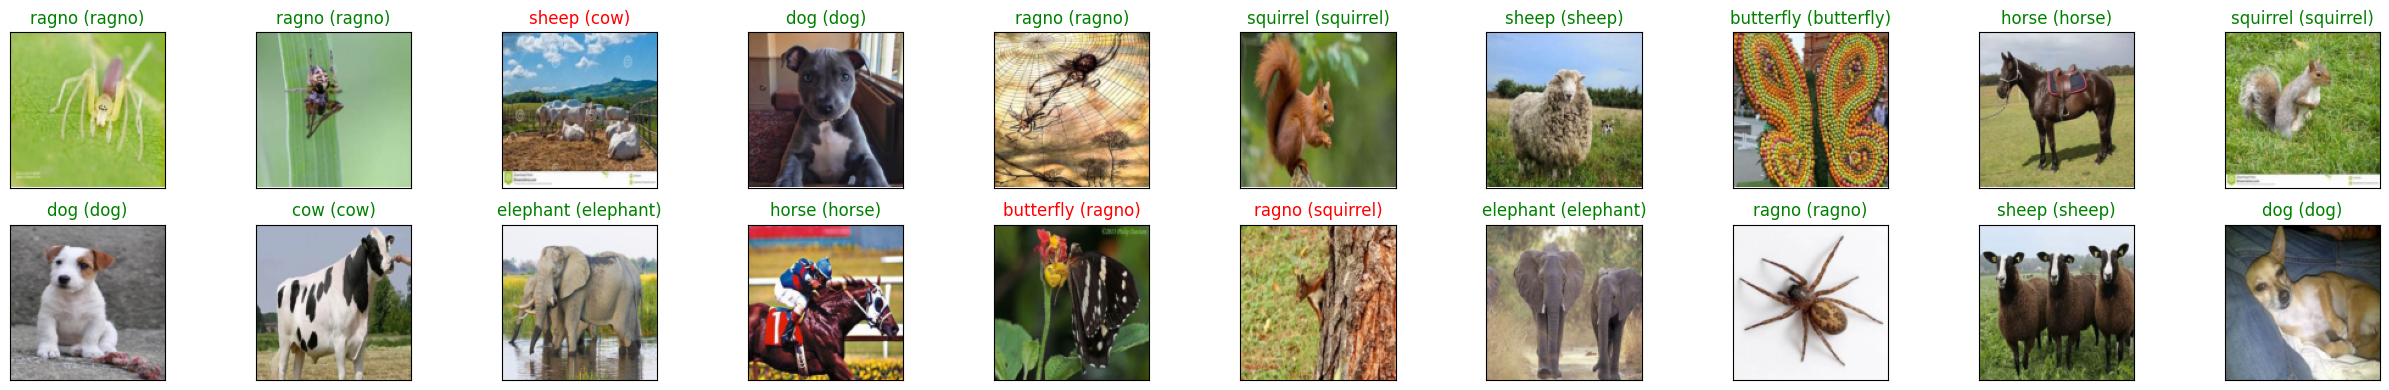

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds_tensor = torch.max(outputs, 1)

preds = preds_tensor.cpu().numpy()
labels = labels.cpu().numpy()
images = images.cpu()

class_to_idx = test_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

fig = plt.figure(figsize=(25, 4))

def imshow(img):
    img = img.numpy() / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    pred_label = idx_to_class[preds[idx]]
    true_label = idx_to_class[labels[idx]]
    ax.set_title(f"{pred_label} ({true_label})",
                 color=("green" if pred_label == true_label else "red"))

plt.tight_layout()
plt.show()

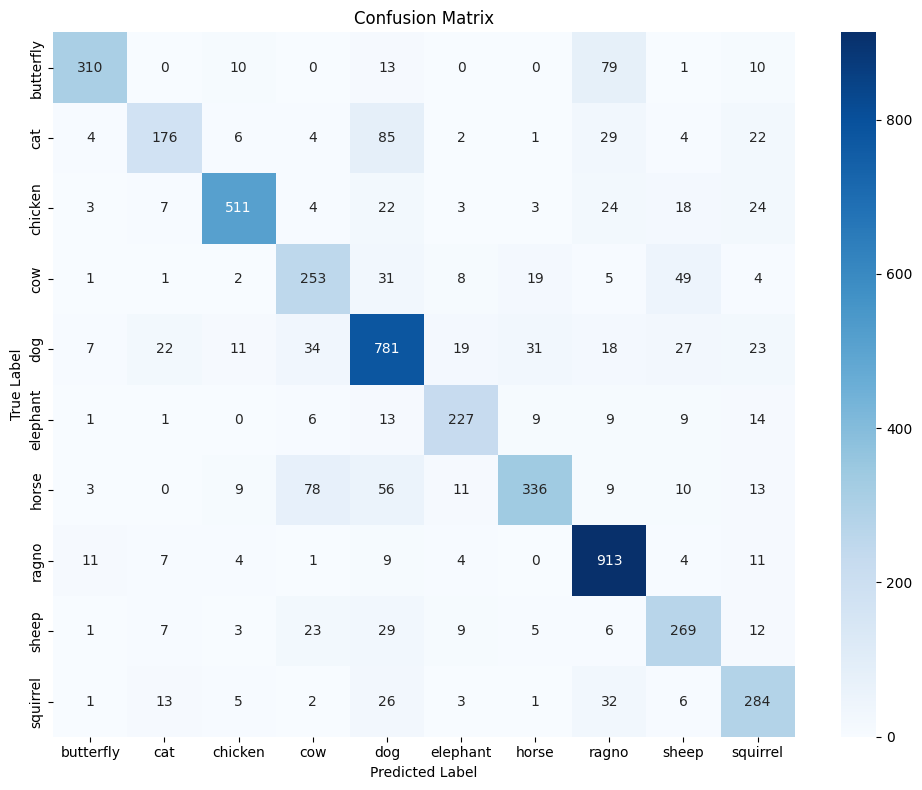

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_to_idx = test_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes = [idx_to_class[i] for i in range(len(idx_to_class))]

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()